In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from models.DSCMS.model import DSCMS
from models.DSCMS import config
from datasets.super_res_dataset import SuperResDataset
from datasets.sr_tiny_dataset import SRTinyDataset
from metrics.image_metrics import mseLoss, ssimLoss, psnrLoss, lpipsLoss, fsimLoss, epiLoss
from metrics.physical_metrics import LossTKE
from typing import Tuple

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\vinic\OneDrive\Área de Trabalho\Outros\tese-vinicius\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vinic\OneDrive\Área de Trabalho\Outros\tese-vinicius\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\vinic\OneDrive\Área de Trabalho\Outros\tese-vinicius\.venv\Lib\site-packages\lpips\weights\v0.1\vgg.pth


In [2]:
# In your evaluation script
test_dataset = SRTinyDataset(
    hr_files=['data/100/window_2023.npy'],
    downsample_factor=4
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,  # or smaller if memory is tight
    shuffle=False  # Don't shuffle test data
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load checkpoint
checkpoint = torch.load('./models/DSCMS/output/weights/DSCMS_best.pth',
                       map_location=torch.device(device))

# Extract just the model state dict
model = DSCMS(2, 2)
model = torch.nn.DataParallel(model)
model = model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

DataParallel(
  (module): DSCMS(
    (activation): ReLU()
    (down_1): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (dsc1_layers): Sequential(
      (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU()
      (4): Upsample(scale_factor=2.0, mode='bilinear')
    )
    (down_2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (dsc2_layers): Sequential(
      (0): Conv2d(34, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU()
      (4): Upsample(scale_factor=2.0, mode='bilinear')
    )
    (down_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dsc3_layers): Sequential(
      (0): Conv2d(34, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReL

In [3]:
def evaluate_model(model, test_loader, device):
    model.eval()
    
    metrics = {
        'mse': {'u': [], 'v': []},
        'ssim': {'u': [], 'v': []},
        'psnr': {'u': [], 'v': []},
        'lpips': {'u': [], 'v': []},
        'fsim': {'u': [], 'v': []},
        'epi':{'u': [], 'v': []},
        'tke': {'u': [], 'v': []}
    }
    
    with torch.no_grad():
        for idx, (lr, hr) in enumerate(test_loader):
            if idx >= 10: break
            lr, hr = lr.to(device), hr.to(device)
            output = model(lr)
            # Compute metrics for each channel
            for channel in range(2):  # u and v components
                channel_label = 'u' if channel == 0 else 'v'
                metrics['mse'][f'{channel_label}'].append(mseLoss(output, hr, channel, idx))
                metrics['ssim'][f'{channel_label}'].append(ssimLoss(output, hr, channel, idx))
                metrics['psnr'][f'{channel_label}'].append(psnrLoss(output, hr, channel, idx))
                metrics['lpips'][f'{channel_label}'].append(lpipsLoss(output, hr, channel, idx))
                metrics['fsim'][f'{channel_label}'].append(fsimLoss(output, hr, channel, idx))
                metrics['epi'][f'{channel_label}'].append(epiLoss(output, hr, channel, idx))
                metrics['tke'][f'{channel_label}'].append(LossTKE(output, hr, channel, idx))

    # Aggregate results
    results = {k: {'u': {'mean': np.mean(v['u']), 'std': np.std(v['u'])},
                    'v': {'mean': np.mean(v['v']), 'std': np.std(v['v'])}}
               for k, v in metrics.items()}
    return results

In [4]:
results = evaluate_model(model, test_loader, device)
print(results)

{'mse': {'u': {'mean': np.float32(0.0016742863), 'std': np.float32(0.00019262417)}, 'v': {'mean': np.float32(0.001557579), 'std': np.float32(0.00010883085)}}, 'ssim': {'u': {'mean': np.float32(0.8218023), 'std': np.float32(0.017785091)}, 'v': {'mean': np.float32(0.8144003), 'std': np.float32(0.029082483)}}, 'psnr': {'u': {'mean': np.float32(32.399284), 'std': np.float32(0.691308)}, 'v': {'mean': np.float32(30.51389), 'std': np.float32(0.2588094)}}, 'lpips': {'u': {'mean': np.float64(0.2868690252304077), 'std': np.float64(0.0076686831773167)}, 'v': {'mean': np.float64(0.24072281867265702), 'std': np.float64(0.029842871834072356)}}, 'fsim': {'u': {'mean': np.float64(0.5023258611891095), 'std': np.float64(0.015665364427051142)}, 'v': {'mean': np.float64(0.5433985962863879), 'std': np.float64(0.024397571568508553)}}, 'epi': {'u': {'mean': np.float64(0.06367795749161324), 'std': np.float64(0.006777643026468366)}, 'v': {'mean': np.float64(0.07897398096829705), 'std': np.float64(0.01093968662

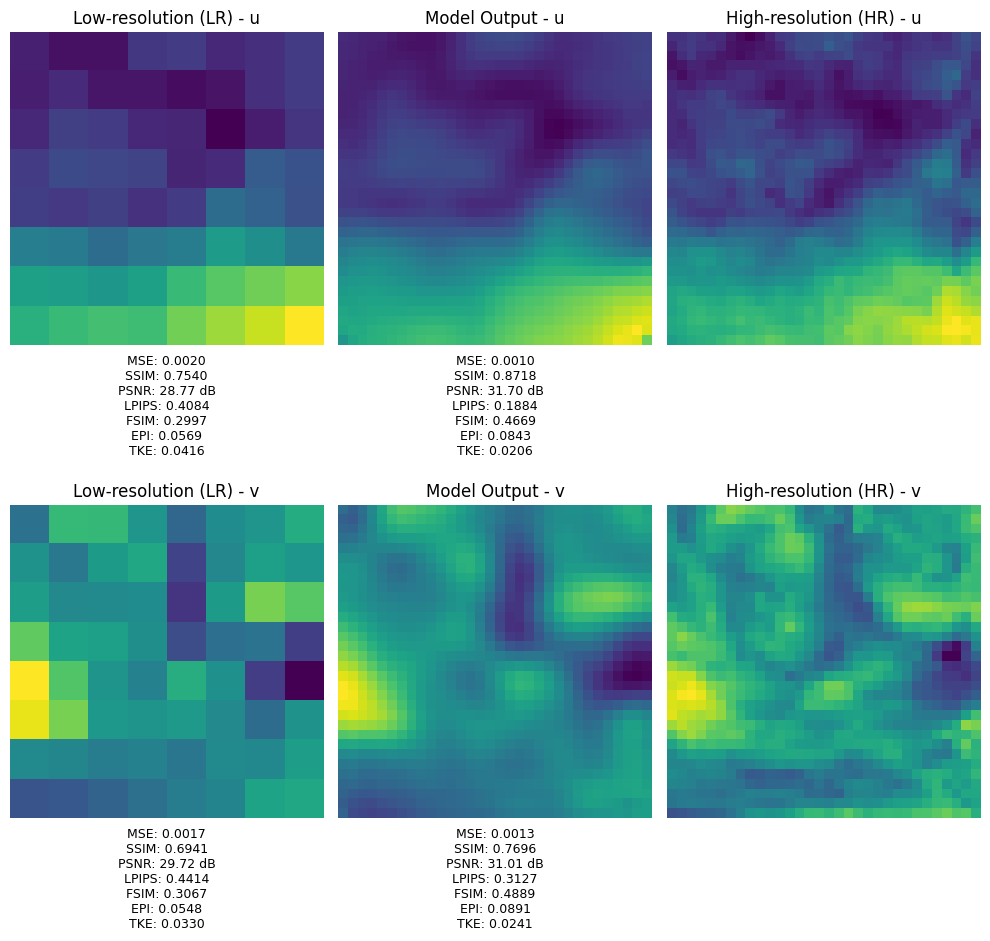

In [5]:
import matplotlib.pyplot as plt
import random

random_idx = random.randint(0, len(test_dataset) - 1)
lr, hr = test_dataset[random_idx]
lr, hr = lr.unsqueeze(0).to(device), hr.unsqueeze(0).to(device)
output = model(lr)

fig, axes = plt.subplots(2, 3, figsize=(10, 10))

for channel in range(2):
    channel_label = 'u' if channel == 0 else 'v'
    axes[channel, 0].imshow(lr[0][channel].cpu().numpy())
    axes[channel, 0].set_title(f'Low-resolution (LR) - {channel_label}')
    axes[channel, 0].axis('off')

    axes[channel, 1].imshow(output[0][channel].detach().cpu().numpy())
    axes[channel, 1].set_title(f'Model Output - {channel_label}')
    axes[channel, 1].axis('off')

    axes[channel, 2].imshow(hr[0][channel].cpu().numpy())
    axes[channel, 2].set_title(f'High-resolution (HR) - {channel_label}')
    axes[channel, 2].axis('off')

    # Compute and display metrics for LR vs HR
    mse_value = mseLoss(lr.detach(), hr.detach(), channel, 0)
    ssim_value = ssimLoss(lr.detach(), hr.detach(), channel, 0)
    psnr_value = psnrLoss(lr.detach(), hr.detach(), channel, 0)
    lpips_value = lpipsLoss(lr.detach(), hr.detach(), channel, 0)
    fsim_value = fsimLoss(lr.detach(), hr.detach(), channel, 0)
    epi_value = epiLoss(lr.detach(), hr.detach(), channel, 0)
    tke_value = LossTKE(lr.detach(), hr.detach(), channel, 0)
    
    axes[channel, 0].text(0.5, -0.35, 
                          f'MSE: {mse_value:.4f}\nSSIM: {ssim_value:.4f}\nPSNR: {psnr_value:.2f} dB\n'
                          f'LPIPS: {lpips_value:.4f}\nFSIM: {fsim_value:.4f}\nEPI: {epi_value:.4f}\nTKE: {tke_value:.4f}',
                          transform=axes[channel, 0].transAxes,
                          ha='center', fontsize=9)

    # Compute and display metrics for Output vs HR
    mse_value = mseLoss(output.detach(), hr.detach(), channel, 0)
    ssim_value = ssimLoss(output.detach(), hr.detach(), channel, 0)
    psnr_value = psnrLoss(output.detach(), hr.detach(), channel, 0)
    lpips_value = lpipsLoss(output.detach(), hr.detach(), channel, 0)
    fsim_value = fsimLoss(output.detach(), hr.detach(), channel, 0)
    epi_value = epiLoss(output.detach(), hr.detach(), channel, 0)
    tke_value = LossTKE(output.detach(), hr.detach(), channel, 0)
    
    axes[channel, 1].text(0.5, -0.35, 
                          f'MSE: {mse_value:.4f}\nSSIM: {ssim_value:.4f}\nPSNR: {psnr_value:.2f} dB\n'
                          f'LPIPS: {lpips_value:.4f}\nFSIM: {fsim_value:.4f}\nEPI: {epi_value:.4f}\nTKE: {tke_value:.4f}',
                          transform=axes[channel, 1].transAxes,
                          ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [6]:
psnrLoss(output.detach(), hr.detach(), 1, 0)

np.float32(31.012589)